## **Calculating the AMOC in latitude-depth coordinates**

### **Description:**

This recipe shows how to calculate the Atlantic Meridional Overturning Circulation (AMOC) stream function in depth-coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---
### **Background:**
The vertical overturning stream function is routinely used to characterise the strength and structure of the AMOC in depth-space as a function of latitude $\phi$ and can be defined at time $t$ as follows:

$$\Psi_{z}(\phi, z, t) = \int_{z}^{\eta} \int_{x_w}^{x_e} v(\lambda, \phi, z, t) \ dx \ dz$$

where the meridional velocity $v(\lambda, \phi, z, t)$ is first integrated zonally between the western $x_w$ and eastern $x_e$ boundaries of the basin before being accumulated vertically from the
sea surface $\eta$ to a specified depth $z(\lambda, \phi)$ (decreasing downward).

---

In [1]:
# -- Import required packages -- #
import xarray as xr
from nemo_cookbook import NEMODataTree

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 JRA-55 model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 669MB
Dimensions:        (y: 331, x: 360, t: 1, z: 75)
Dimensions without coordinates: y, x, t, z
Data variables: (12/58)
    atlmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1f            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    pacmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    socmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 5.2.2 (Homepage = http://nco.sf.net, C...
    history:  Fri Oct  4 10:58:13 2024: ncks -O --4 --no_abc --cnk_plc=xpl --...

**Next, we need to import the meridional velocity and vertical grid cell thicknesses stored at V-points in a single dataset.**

**Typically, NEMO model outputs defined on V-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridV.nc` file(s).**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/V1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridV = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['e3v', 'vo']], compat="override")

ds_gridV

<xarray.Dataset> Size: 4GB
Dimensions:        (depthv: 75, y: 331, x: 360, time_counter: 49)
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 392B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
Dimensions without coordinates: y, x
Data variables:
    e3v            (time_counter, depthv, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    vo             (time_counter, depthv, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 3600 s)
    interval_operation:  3600 s
    interval_write:      1 yr
    long_name:           V-cell thickness
    online_operation:    average
    standard_name:       cell_thickness
    units:               m

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and V-grid variables for the eORCA1 model.**

In [4]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain.rename({"z": "nav_lev"}), "gridV": ds_gridV}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 49)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 392B dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphit         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1t           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level     (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level  (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:        (time_counter: 49, k: 75, j: 331, i: 360)
│       Coordinates:
│         * depthv         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 392B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphiv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e3v            (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           vo             (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           e1v            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           cell_methods:        time: mean (interval: 3600 s)
│           interval_operation:  3600 s
│           interval_write:      1 yr
│           long_name:           V-cell thickness
│           online_operation:    average
│           standard_name:       cell_thickness
│           units:               m

### **Calculating the AMOC vertical overturning stream function**
**Now we have constructed our `NEMODataTree`, let's calculate the vertical overturning stream function.**

In this example, our eORCA1 model uses $z^{*}$ vertical coordinates, so using `integral()`, which supports integration along the $i$, $j$, $k$ dimensions of the NEMO model grid, is appropriate. However, this would not be the case if using a NEMO model with geopotential / terrain-following coordinates.**

In [5]:
atlmask = ds_domain['atlmsk'].rename({"x":"i", "y":"j"})

moc_z_atl = nemo.integral(grid="/gridV",
                          var="vo",
                          dims=["i", "k"], 
                          cum_dims=["k"],
                          dir="+1",
                          mask=atlmask
                          )

moc_z_atl

<xarray.DataArray 'vo' (time_counter: 49, k: 75, j: 331)> Size: 10MB
dask.array<nancumsum, shape=(49, 75, 331), dtype=float64, chunksize=(1, 25, 331), chunktype=numpy.ndarray>
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
  * depthv         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) datetime64[ns] 392B dask.array<chunksize=(1,), meta=np.ndarray>
  * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
  * j              (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5

**Notice that the resulting DataArray includes a dask array, so we haven't actually computed the vertical overturning yet. To do this, we need to call the ``.compute()`` method:**

In [6]:
# Compute vertical overturning stream function in Sverdrups [1 Sv = 1E6 m3/s]:
moc_z_atl = 1E-6 * moc_z_atl.compute()

moc_z_atl

<xarray.DataArray 'vo' (time_counter: 49, k: 75, j: 331)> Size: 10MB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.93256017e-03, -5.98465019e-03, -4.70669708e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.23823036e-02, -1.24593425e-02, -9.82934168e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.93505099e-02, -1.93588036e-02, -1.51586968e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.30921961e-01, -9.31773471e-01, -9.32592128e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.30921961e-01, -9.31773471e-01, -9.32592128e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.30921961e-01, -9.31773471e-01, -9.32592128e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.31946621e-03, -9.62942149e-03, -1.12506309e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.87225095e-02, -1.92967880e-02, -2.25915142e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.81349402e-02, -2.89098083e-02, -3.37560596e-02],
...
         -8.73345777e-01, -8.73976184e-01, -8.73915069e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -8.73345777e-01, -8.73976184e-01, -8.73915069e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -8.73345777e-01, -8.73976184e-01, -8.73915069e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      shape=(49, 75, 331))
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
  * depthv         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) datetime64[ns] 392B 1976-07-02 ... 2024-07-02
  * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
  * j              (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5

### **Visualising the time-mean AMOC vertical overturning stream function**

**Finally, let's visualise the results by plotting the time-mean Atlantic Meridional Overturning stream function in depth-coordinates:**

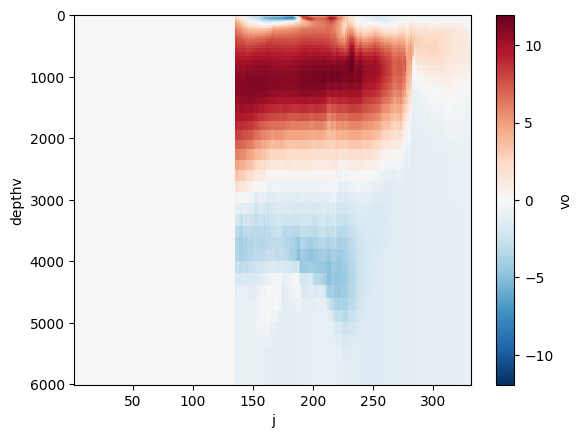

In [7]:
moc_z_atl.mean(dim='time_counter').plot(y='depthv', yincrease=False)